![Wordcloud](/images/wordcloud.png)

__Insights into Toronto’s Foodservice Market__ // __IBM Capstone Project__

_Krishnakanth Allika_

_August 2019_

__Abstract__

The IBM capstone project delivers valuable decision driven insights into Toronto's foodservice industry by employing modern-day data science tools. _K means_, an unsupervised clustering algorithm is applied to segregate the city's restaurant market into clusters based on the types of restaurants established in the city. Relationship between foodservice market of a neighbourhood and its location relative to the city centre along with relationships within various types of restaurants are analysed using inferential statistics.

# Introduction/Business Understanding

## Background

By 2022, quick-service restaurants are expected to remain the largest segment in the foodservice industry in Canada followed by full-service restaurants. However, Toronto’s landscape is unique compared to the rest of the country. Toronto has comparatively higher percentages of coffee shops and fine dining restaurants compared to the national average. There are also more restaurants serving European menus in Toronto than in other places, whereas the “hamburger” type menus are relatively scarce in the city. It is interesting to note that Toronto has a very strong presence of independently owned restaurants making up more than 90% of the city’s foodservice market. 
    
## Area of Interest

With a blooming foodservice market, Toronto constantly attracts new restaurants and eateries. The target audience of the project are the investors and potential restaurant owners are often faced with several market research questions such as the current market landscape in the area of interest, the type of restaurant that fits well with the neighbourhood, the best location for a particular type of restaurant, etc. However, since Toronto's foodservice market is unique to itself, new owners cannot simply rely on a nationwide analysis. A city-specific analysis is what would benefit anyone who intends to start a new restaurant in Toronto and that is precisely what this project presents.
    
## Problem Statement

This project aims to provide valuable insights into Toronto’s current foodservice market such as distribution of restaurant types by locations, variations in density of restaurants and suggestive analysis of types of restaurants to benefit new and potential restaurant owners and investors.
    

# Analytical Approach

## Clustering

The approach is to categorize types of restaurants in Toronto into various clusters and map them to their geographical locations. A visualization map of Toronto would illustrate these clusters cast across its postal codes. 
    
## Correlation

Further analysis is done to identify any correlation between restaurants in the neighbourhood and its distance from the city centre, and any significant correlations within types of restaurants.

# Data Acquisition

## Data requirements

The data required for the project includes the list of postal codes of the city, types of restaurants in each location, number of restaurants of each type, distances of restaurants from the city centre, and the geographical coordinates of the postal codes to visualize the data in a map.
    
## Data collection

### Neighbourhood data

Postal code data for Toronto is scraped from the following Wikipedia page:

Source: [https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)

Data points:

* Postal code

* Borough

* Neighbourhood
    
### Geographical coordinates

Geographical coordinates data is extracted using Mapquest’s Geocoding API:

Source: [https://developer.mapquest.com/documentation/geocoding-api/](https://developer.mapquest.com/documentation/geocoding-api/)

Alternate source (Google API): [https://link.datascience.eu.org/p001d1](https://link.datascience.eu.org/p001d1)

Data points:

* Postal code

* Latitude

* Longitude

    
### Foodservice market data

Restaurant data is extracted from FourSquare’s Places API. FourSquare data is classified into various categories and sub-categories. Categories are identified by the tag "Category ID". The category of interest here is __Food__ and the category ID for food is _4d4b7105d754a06374d81259_. The sub-categories of the food category are various types of restaurants located in the venue.

Source: [https://developer.foursquare.com/docs/api/endpoints](https://developer.foursquare.com/docs/api/endpoints)

Data points:

* Postal code

* Venue Latitude

* Venue Longitude

* Venue category

* Venue subcategory


Table 1. Data points and data sources.

| Datapoint 	| Source 	|
|:--------------	|:----------------------	|
| Postal Code 	| Wikipedia 	|
| Borough 	| Wikipedia 	|
| Neighbourhood 	| Wikipedia 	|
| Postal Code 	| MapQuest Geocoding API 	|
| Latitude 	| MapQuest Geocoding API 	|
| Longitude 	| MapQuest Geocoding API 	|
| Postal Code 	| FourSquare Places API 	|
| Venue Latitude 	| FourSquare Places API 	|
| Venue Longitude 	| FourSquare Places API 	|
| Venue Category 	| FourSquare Places API 	|
| Venue Subcategory 	| FourSquare Places API 	|

## Code for data collection

### Importing libraries

In [1]:
import numpy as np  # Numpy library
import pandas as pd  # library for data analysis
import json  # library to handle JSON files
import geocoder  # convert an address into latitude and longitude values
from geopy.geocoders import Nominatim  # convert an address into latitude and longitude values
import requests  # library to handle requests
import matplotlib.cm as cm  # Matplotlib and associated plotting modules
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans  # import k-means from clustering stage
import folium  # map rendering library
import seaborn as sns  # Seaborn
from scipy.stats import pearsonr  # Pearson correlation library
from getpass import getpass as gp  # to hide API keys from being displayed
from tabulate import tabulate  # to pretty print tabular data

In [2]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

### Scraping neighbourhood data from the web

Since the neighbourhood and postal code data is already in the form of a table, we can use the pandas read_html which looks for tabular data and loads it into a data frame

In [2]:
df_PostalCodes = \
    pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
                 )[0]

### Collecting geographical coordinates from MapQuest

Documentation for MapQuest Geocoding API is available at [https://geocoder.readthedocs.io/providers/MapQuest.html](https://geocoder.readthedocs.io/providers/MapQuest.html)

In [4]:
MapQuest_key = gp("Enter your MapQuest API key")

Enter your MapQuest API key ································


In [39]:
# Collecting coordinates from MapQuest geocode API for a sample of 5 postal codes.

sample = 5
df_MQ_Coordinates = pd.DataFrame(columns=['Latitude', 'Longitude'])
for i in range(sample):
    g = geocoder.mapquest(df_PostalCodes.loc[i, 'Postcode']
                          + ', Toronto, Ontario', key=MapQuest_key)
    df_MQ_Coordinates.loc[i] = g.latlng

### Extracting types of restaurants from FourSquare

FourSquare's category ID for Food is _4d4b7105d754a06374d81259_. Venues will be searched in each neighbourhood by this category ID. The restaurant type, which is the sub-category, of each venue is extracted. If there are no restaurants in a neighbourhood, then the restaurant type will be assigned as "No Restaurants".

In [34]:
FourSquare_client_ID = gp('Enter your FourSquare Client ID')
FourSquare_client_secret = gp('Enter your FourSquare Client Secret')
FourSquare_API_version = '20190801'  # Foursquare API version

Enter your FourSquare Client ID ················································
Enter your FourSquare Client Secret ················································


In [40]:
# Extracting restaurant data for a sample of 5 locations

df_MQ_Location = pd.concat([df_PostalCodes.head(sample),
                           df_MQ_Coordinates], axis=1)
df_RestaurantTypes = pd.DataFrame(columns=['RestaurantType',
                                  'PostalCode'])
for (index, row) in df_MQ_Location.iterrows():
    limit = 100  # limit of number of venues returned by Foursquare API
    radius = 300  # define radius
    cat_id = '4d4b7105d754a06374d81259'  # Category: Food
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        FourSquare_client_ID,
        FourSquare_client_secret,
        FourSquare_API_version,
        row['Latitude'],
        row['Longitude'],
        radius,
        limit,
        cat_id,
        )
    df_results = pd.DataFrame(list(venue['categories'][0]['name']
                              for venue in
                              requests.get(url).json()['response']['venues']), columns=['RestaurantType'])
    if df_results.shape[0] == 0:
        df_results.loc[0, ['RestaurantType']] = 'No Restaurants'
    df_results['PostalCode'] = row['Postcode']
    df_RestaurantTypes = pd.concat([df_RestaurantTypes, df_results])
df_RestaurantTypes.reset_index(drop=True, inplace=True)

# Data Preparation and Feature Extraction

## Data understanding

In [41]:
# Checking neighbourhood data

print('Shape:', df_PostalCodes.shape)
df_PostalCodes.head()

Shape: (288, 3)


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


The neighbourhood data contains the variables Postcode, Borough and Neighbourhood. 

In [42]:
# Checking geographical coordinates data

print('Shape:', df_MQ_Coordinates.shape)
df_MQ_Coordinates.head()

Shape: (5, 2)


,Latitude,Longitude
0,43.63175,-79.41944
1,43.63175,-79.41944
2,43.76523,-79.33701
3,43.73279,-79.31051
4,43.65331,-79.36646


The geographical data from MapQuest contains variables PostalCode, Latitude and Longitude.

In [43]:
df_RestaurantTypes.head()

,RestaurantType,PostalCode
0,Food Truck,M1A
1,Poutine Place,M1A
2,Fast Food Restaurant,M1A
3,Wings Joint,M1A
4,Donut Shop,M1A


The FourSquare API data contains records of variables RestaurantType and PostalCode.

## Data Preperation

### Postal code and neighbourhood data

In [3]:
# Renaming column names

df_PostalCodes.rename(columns={'Postcode': 'PostalCode'}, inplace=True)

# Ignore cells with a borough that is 'Not assigned'

df_PostalCodes = df_PostalCodes.query("Borough != 'Not assigned'"
        ).reset_index(drop=True)

# Combining neighbourhoods belonging to same postal code

df_PostalCodes = df_PostalCodes.groupby('PostalCode',
        as_index=False).agg(lambda x: ', '.join(sorted(set(x))))

# Assigning borough names to 'Not assigned' neighbourhoods

df_PostalCodes.loc[df_PostalCodes['Neighbourhood'] == 'Not assigned',
                   'Neighbourhood'] = df_PostalCodes['Borough']
df_PostalCodes.head(5)

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [56]:
print('Shape:', df_PostalCodes.shape)

Shape: (103, 3)


The extracted data contains numerous issues that were fixed. The neighbourhood data contained postal codes without any boroughs assigned which were dropped. Some neighbourhoods were not assigned a neighbourhood name, so their borough names were assigned to them. In some cases, more than one neighbourhood shared the same postal code. After fixing these issues, the data contained 103 records of postal code data.

In [22]:
# Extracting coordinates data from MapQuest API

df_MQ_Coordinates = pd.DataFrame(columns=['Latitude', 'Longitude'])
for i in range(df_PostalCodes.shape[0]):
    g = geocoder.mapquest(df_PostalCodes.loc[i, 'PostalCode']
                          + ', Toronto, Ontario', key=MapQuest_key)
    df_MQ_Coordinates.loc[i] = g.latlng

__Plotting a map of neighbourhoods with MapQuest data__

In [4]:
address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent='my-application')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto, Ontario are {}, {}.'.format(latitude,
        longitude))

The geograpical coordinates of Toronto, Ontario are 43.653963, -79.387207.


In [24]:
df_MQ_Location = pd.concat([df_PostalCodes, df_MQ_Coordinates], axis=1)
map_Toronto_MapQuest = folium.Map(location=[latitude + 0.07,
                                  longitude], zoom_start=11)  # Offset to centre the map around neighbourhoods

# add markers to the map

for (lat, lon, pc, nbh) in zip(df_MQ_Location['Latitude'],
                               df_MQ_Location['Longitude'],
                               df_MQ_Location['PostalCode'],
                               df_MQ_Location['Neighbourhood']):
    label = folium.Popup('{}: {}'.format(pc, nbh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False,
        ).add_to(map_Toronto_MapQuest)
map_Toronto_MapQuest

The geographical coordinates data extracted from MapQuest had some concerns too. The postal code data is merged with the coordinates and plotted on a map to get a basic understanding of the data. Following image displays a map of Toronto with neighbourhood markers overlayed on it. It was observed that the MapQuest latitude and longitude were not accurate and many of the nearby neighbourhoods had the same coordinates. 

![Fig 01. Toronto neighbourhood map using MapQuest API coordinates](images/map01_MQ.png)

So the coordinates data is replaced by the data extracted from the alternate source, a static CSV file of Google API output. The following image displays a map of Toronto with the neighbourhoods as markers. The latitude of the map is offset by 0.07 to centre the map around the neighbourhoods.

__Plotting a map of neighbourhoods with the CSV data from Google API__

In [5]:
df_csv_Coordinates = pd.read_csv('http://link.datascience.eu.org/p001d1')
df_csv_Coordinates.rename(columns={'Postal Code': 'PostalCode'},
                          inplace=True)
df_csv_Location = pd.merge(df_PostalCodes, df_csv_Coordinates,
                           on='PostalCode')

In [8]:
map_Toronto_CSV = folium.Map(location=[latitude + 0.07, longitude],
                             zoom_start=11)

# add markers to the map

for (lat, lon, pc, nbh) in zip(df_csv_Location['Latitude'],
                               df_csv_Location['Longitude'],
                               df_csv_Location['PostalCode'],
                               df_csv_Location['Neighbourhood']):
    label = folium.Popup('{}: {}'.format(pc, nbh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False,
        ).add_to(map_Toronto_CSV)
map_Toronto_CSV

![Fig 02. Toronto neighbourhood map using Google API coordinates](images/map02_CSV.png)

Examining the maps above, it is evident that the coordinates data from Google API is of better quality than that of MapQuest. Hence, the MapQuest data is discarded and Google coordinates data is used.

In [58]:
df_Location = df_csv_Location.drop(['Borough'], axis=1)
df_Location.head()

,PostalCode,Neighbourhood,Latitude,Longitude
0,M1B,"Malvern, Rouge",43.806686,-79.194353
1,M1C,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Woburn,43.770992,-79.216917
4,M1H,Cedarbrae,43.773136,-79.239476


### FourSquare Restaurant data

In [59]:
df_RestaurantTypes = pd.DataFrame(columns=['RestaurantType',
                                  'PostalCode'])
for (index, row) in df_Location.iterrows():
    limit = 100  # limit of number of venues returned by Foursquare API
    radius = 300  # define radius
    cat_id = '4d4b7105d754a06374d81259'  # Category: Food
    url = \
        'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        FourSquare_client_ID,
        FourSquare_client_secret,
        FourSquare_API_version,
        row['Latitude'],
        row['Longitude'],
        radius,
        limit,
        cat_id,
        )
    df_results = pd.DataFrame(list(venue['categories'][0]['name']
                              for venue in
                              requests.get(url).json()['response'
                              ]['venues']), columns=['RestaurantType'])
    if df_results.shape[0] == 0:
        df_results.loc[0, ['RestaurantType']] = 'No Restaurants'
    df_results['PostalCode'] = row['PostalCode']
    df_RestaurantTypes = pd.concat([df_RestaurantTypes, df_results])
df_RestaurantTypes.reset_index(drop=True, inplace=True)

In [60]:
# Checking FourSquare data

print('Shape:', df_RestaurantTypes.shape)
df_RestaurantTypes.head()

Shape: (1567, 2)


,RestaurantType,PostalCode
0,No Restaurants,M1B
1,No Restaurants,M1C
2,Restaurant,M1E
3,Bakery,M1E
4,Chinese Restaurant,M1E


The FourSquare API returned 1564 records of variables RestaurantType and PostalCode, of which, some locations did not have any restaurants within the specified radius. The _RestaurantType_ variable for such locations was marked as _No Restaurants_.

## Feature Extraction

In [61]:
df_Data = pd.merge(df_Location, df_RestaurantTypes, on='PostalCode')
df_Data.head()

,PostalCode,Neighbourhood,Latitude,Longitude,RestaurantType
0,M1B,"Malvern, Rouge",43.806686,-79.194353,No Restaurants
1,M1C,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497,No Restaurants
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Restaurant
3,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Bakery
4,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Chinese Restaurant


Along with the extracted features such as _PostalCode_, _Neighbourhood_, _Latitude_, _Longitude_ and _RestaurantType_, a new variable for the distance of the location from the city centre is added as _Distance_. 

The __Distance__ of a location _x1_ from the city centre _x_ is calculated using the famous Pythagoras theorem. However, latitudes and longitudes do not follow the same scale throughout the globe. The distance between any two consecutive latitudes is 111 kilometres, but the distance between two consecutive longitudes varies depending on where on Earth we are measuring it. The distance between two longitudes at the Equator is 111 kilometres but it gradually decreases as we move away from the Equator and toward the poles. The information at the [National Oceanic and Atmospheric Administration](https://www.nhc.noaa.gov/gccalc.shtml) website is used to calculate the approximate distance between two consecutive longitudes in Toronto to be 80 kilometres. The following image illustrates the calculation of the distance of a location from Toronto city centre.

![Fig 03. Distance of a location from city centre using Pythagoras theorem](../images/distance1A.png)

In [62]:
# Distance between two consecutive longitudes in Toronto in kilometers
dLng = 80
# Distance between two consecutive latitudes in kilometers
dLat = 111
df_Data.insert(4, 'Distance', (((df_Data['Longitude'] - longitude)
               * dLng) ** 2 + ((df_Data['Latitude'] - latitude) * dLat)
               ** 2) ** 0.5)
df_Data.head()

,PostalCode,Neighbourhood,Latitude,Longitude,Distance,RestaurantType
0,M1B,"Malvern, Rouge",43.806686,-79.194353,22.921869,No Restaurants
1,M1C,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497,23.216478,No Restaurants
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,20.004767,Restaurant
3,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,20.004767,Bakery
4,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,20.004767,Chinese Restaurant


Following are the extracted and calculated features of the data frame __df_Data__ used in the analysis.


| **Feature**    | **Source**                            | **Description**                                                             | **Purpose**                                                                                                                                                                                        |
|:----|:----|:----|:----|
| PostalCode     | Extracted from Wikipedia              | A three\-letter alphanumeric postcode of a neighbourhood in Toronto         | Primary key to merge various data frames\.                                                                                                                                                          |
| Neighbourhood  | Extracted from Wikipedia              | One or more neighbourhood names that fall within the area of the postcode\. | A key variable around which the analysis is done\. Also used as markers on the map\.                                                                                                               |
| Latitude      | Extracted from MapQuest or Google API | Latitude of the postcode in decimal units\.                                | To locate neighbourhoods on the map and to calculate the distance of a location from the city centre\.                                                                                                 |
| Longitude      | Extracted from MapQuest or Google API | Longitude of the postcode in decimal units\.                                | To locate neighbourhoods on the map and to calculate the distance of a location from the city centre\.                                                                                                 |
| Distance       | Calculated                            | Distance of a location from the city centre in kilometres\.                     | To calculate the correlation between the distance of a location from the city centre and the number of restaurants in the location\.                                                                   |
| RestaurantType | Extracted from FourSquare API         | Type of a restaurant\.                                                      | To partition the city of Toronto into various clusters based on restaurant types located in the city\. Also used to find possible correlations between various restaurant types within the city\. |


In [82]:
# Run this code if you are not using FourSquare API
# A copy of df_Data data frame is available for download
# from https://link.datascience.eu.org/p001d2

df_Data = pd.read_csv('http://link.datascience.eu.org/p001d2', encoding='utf-8')
df_Data.head()

,PostalCode,Neighbourhood,Latitude,Longitude,Distance,RestaurantType
0,M1B,"Malvern, Rouge",43.806686,-79.194353,22.921869,No Restaurants
1,M1C,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497,23.216478,No Restaurants
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,20.004767,Bakery
3,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,20.004767,Restaurant
4,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,20.004767,Chinese Restaurant


# Exploratory Data Analysis - Clustering Toronto neighbourhoods by restaurant types

## K-Means Clustering

Clustering or cluster analysis is the process of dividing data into groups (clusters) in such a way that objects in the same cluster are more similar to each other than those in other clusters. The goal is to divide Toronto neighbourhoods into various groups based on the __top 10__ types of restaurants located in the neighbourhoods. There are various models and techniques for cluster analysis. K-means clustering is a simple unsupervised learning algorithm that is commonly used for market segmentation. The __RestaurantType__ column is first one-hot encoded and grouped by __PostalCode__.

One-hot encoding and grouping by postal codes

In [72]:
df_Clusters = df_Data.copy()

# df_OneHot = pd.get_dummies(df_Clusters[["RestaurantType"]], prefix="", prefix_sep="", drop_first=True)

df_Clusters = df_Clusters.drop('RestaurantType',
                               axis=1).join(pd.get_dummies(df_Clusters[['RestaurantType'
        ]], prefix='', prefix_sep=''))
print(df_Clusters.shape)
df_Clusters.head(5)

(1564, 125)


,PostalCode,Neighbourhood,Latitude,Longitude,Distance,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
0,M1B,"Malvern, Rouge",43.806686,-79.194353,22.921869,...,0,0,0,0,0
1,M1C,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497,23.216478,...,0,0,0,0,0
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,20.004767,...,0,0,0,0,0
3,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,20.004767,...,0,0,0,0,0
4,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,20.004767,...,0,0,0,0,0


In [73]:
df_Clusters = df_Clusters.groupby(['PostalCode', 'Neighbourhood',
                                  'Latitude', 'Longitude', 'Distance'
                                  ]).sum().reset_index()
print(df_Clusters.shape)
df_Clusters.head()

(103, 125)


,PostalCode,Neighbourhood,Latitude,Longitude,Distance,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
0,M1B,"Malvern, Rouge",43.806686,-79.194353,22.921869,...,0,0,0,0,0
1,M1C,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497,23.216478,...,0,0,0,0,0
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,20.004767,...,0,0,0,0,0
3,M1G,Woburn,43.770992,-79.216917,18.823836,...,0,0,0,0,0
4,M1H,Cedarbrae,43.773136,-79.239476,17.738704,...,0,0,0,0,0


Following are the top 10 types of restaurants in Toronto

In [74]:
top_count = 10  # Number of top restaurant types
top_restaurant_types = df_Clusters[list(df_Clusters.iloc[:, 5:
                                   ])].sum(axis=0).reset_index().sort_values(by=0,
        ascending=False).iloc[:top_count]['index'].values.tolist()
print(tabulate(pd.DataFrame({'Top 10 restaurant types': top_restaurant_types}).set_index('Top 10 restaurant types'
               ), headers='keys', tablefmt='psql'))

+---------------------------+
| Top 10 restaurant types   |
|---------------------------|
| Coffee Shop               |
| Café                      |
| Restaurant                |
| Pizza Place               |
| Fast Food Restaurant      |
| Italian Restaurant        |
| Sandwich Place            |
| Bakery                    |
| Sushi Restaurant          |
| Breakfast Spot            |
+---------------------------+


**Determining the optimal _k_**

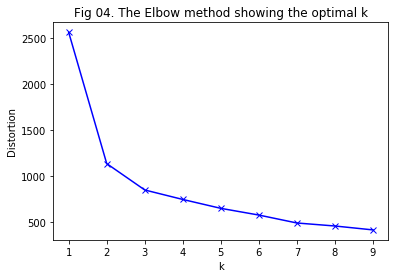

In [75]:
# Determining optimal k

df_kmeans = df_Clusters[top_restaurant_types]
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=3).fit(df_kmeans)
    distortions.append(kmeans.inertia_)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Fig 04. The Elbow method showing the optimal k')
plt.show()

The optimal value of the number of clusters, _k_, is determined using the __elbow method__ to be __3__.

In [76]:
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=3).fit(df_kmeans)
# df_Clusters.insert(2, 'Cluster', kmeans.labels_)
df_Clusters['Cluster']=kmeans.labels_
df_Clusters.head(5)

,PostalCode,Neighbourhood,Latitude,Longitude,Distance,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Cluster
0,M1B,"Malvern, Rouge",43.806686,-79.194353,22.921869,...,0,0,0,0,0
1,M1C,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497,23.216478,...,0,0,0,0,0
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,20.004767,...,0,0,0,0,0
3,M1G,Woburn,43.770992,-79.216917,18.823836,...,0,0,0,0,0
4,M1H,Cedarbrae,43.773136,-79.239476,17.738704,...,0,0,0,0,0


The neighbourhoods are grouped into three clusters. The following table shows the cluster number and the number of neighbourhoods in each cluster.

In [77]:
# Pretty-printing clusters in tabular format.

print(tabulate(df_Clusters['Cluster'
               ].value_counts().sort_index().to_frame(),
               headers=['Cluster number',
               'Neighbourhoods in the cluster'], tablefmt='psql',
               colalign=('center', 'center')))

+------------------+---------------------------------+
|  Cluster number  |  Neighbourhoods in the cluster  |
|------------------+---------------------------------|
|        0         |               79                |
|        1         |               13                |
|        2         |               11                |
+------------------+---------------------------------+


In [79]:
# This code is optional
# A copy of df_Clusters is available for download
# at https://link.datascience.eu.org/p001d3

df_Clusters = pd.read_csv('http://link.datascience.eu.org/p001d3', encoding='utf-8')
df_Clusters.head()

,PostalCode,Neighbourhood,Latitude,Longitude,Distance,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Cluster
0,M1B,"Malvern, Rouge",43.806686,-79.194353,22.921869,...,0,0,0,0,0
1,M1C,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497,23.216478,...,0,0,0,0,0
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,20.004767,...,0,0,0,0,0
3,M1G,Woburn,43.770992,-79.216917,18.823836,...,0,0,0,0,0
4,M1H,Cedarbrae,43.773136,-79.239476,17.738704,...,0,0,0,0,0


## Visualization

The image is a visualization of neighbourhood clusters displayed on a map of Toronto. Each cluster is marked by a different colour to easily distinguish it from other clusters. The map enables viewers to visualize the locations of the city fall into various segregations based on their types of restaurants.

In [83]:
# create map

map_clusters = folium.Map(location=[latitude + 0.07, longitude],
                          tiles='OpenStreetMap', zoom_start=11)

# set color scheme for the clusters

colours = ['green', 'blue', 'red']

# add markers to the map

markers_colors = []
for (lat, lng, pc, nbh, cluster) in zip(df_Clusters['Latitude'],
        df_Clusters['Longitude'], df_Clusters['PostalCode'],
        df_Clusters['Neighbourhood'], df_Clusters['Cluster']):
    label = folium.Popup(str(pc) + ': ' + str(nbh) + ' Cluster '
                         + str(cluster), parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colours[cluster],
        fill=True,
        fill_color=colours[cluster],
        fill_opacity=0.6,
        ).add_to(map_clusters)
map_clusters

![Fig 05. Map of Toronto clustered by restaurant types](images/map03_ClustersA.png)

## Market insights

Examining each cluster individually and then by comparing it with other clusters provides valuables insights into Toronto's foodservice market. 

In [84]:
for colour in sorted(colours, reverse=True):
    df = df_Clusters.loc[df_Clusters['Cluster']
                         == colours.index(colour)].copy()
    df.drop([
        'PostalCode',
        'Neighbourhood',
        'Latitude',
        'Longitude',
        'Distance',
        'Cluster',
        ], axis=1, inplace=True)
    Rcount = df.sum().sum()
    Ncount = df.shape[0]
    N0count = df['No Restaurants'].sum()
    RperN = int(round(Rcount / (Ncount - N0count)))
    N0percentage = int(round(N0count * 100 / Ncount))
    print('''Cluster: {}
Restaurants in the cluster: {}
Neighbourhoods in the cluster: {}
Percentage of neighbourhoods without restaurants: {}%
Restaurants per neighbourhood: {}'''.format(colour.title(),
            Rcount, Ncount, N0percentage, RperN))
    print(tabulate(df.sum().sort_values(ascending=False).head().to_frame(),
           headers=['Top restaurant types in the cluster', 'Count'
           ], tablefmt='psql'), '\n')

Cluster: Red
Restaurants in the cluster: 549
Neighbourhoods in the cluster: 11
Percentage of neighbourhoods without restaurants: 0%
Restaurants per neighbourhood: 50
+---------------------------------------+---------+
| Top restaurant types in the cluster   |   Count |
|---------------------------------------+---------|
| Coffee Shop                           |     125 |
| Restaurant                            |      38 |
| Café                                  |      23 |
| Food Court                            |      20 |
| Fast Food Restaurant                  |      19 |
+---------------------------------------+---------+ 

Cluster: Green
Restaurants in the cluster: 443
Neighbourhoods in the cluster: 79
Percentage of neighbourhoods without restaurants: 25%
Restaurants per neighbourhood: 8
+---------------------------------------+---------+
| Top restaurant types in the cluster   |   Count |
|---------------------------------------+---------|
| Coffee Shop                           

The red cluster has 11 neighbourhoods that are located closest to the city centre. With 50 restaurants per neighbourhood, it has the highest density of restaurants in the city. Besides having the highest number of coffee shops, it also has a high number of restaurants followed by food courts and fast food centres. It is also interesting to note that all neighbourhoods in this group have restaurants. This cluster is a thriving market for foodservice industry but start-ups may also face stiff competition. 

The green cluster consists of 79 neighbourhoods. This group has the lowest concentration of 8 restaurants per neighbourhood. It's top food services are coffee shops, café, fast food restaurants and pizza places. The number of restaurants of each type is more or less proportional, unlike the red cluster where the coffee shops were about three times more than any other restaurant type. It is important to note that 25% of these neighbourhoods have no restaurants at all. This is a great opportunity for new start-ups to perform further market research. This cluster is also spread out uniformly throughout the city. With moderate competition and a variety of restaurant types, the neighbourhoods in this cluster might be a good choice to start up a new restaurant, especially if it is from the top restaurant categories of this cluster.

The blue cluster consists of 13 neighbourhoods with a high average concentration of 44 restaurants per neighbourhood. All neighbourhoods have restaurants. This cluster has the most proportionally distributed types of restaurants of all. Though coffee shops dominate the market, there are a good number of pizza places, cafés, Italian and other restaurants. These neighbourhoods are possibly one of the promising locations to start a new pizza place or an Italian restaurant.

# Inferential Data Analysis

In [85]:
df_correlation = df_Clusters.drop(['PostalCode', 'Neighbourhood',
                                  'Cluster', 'Latitude', 'Longitude'],
                                  axis=1)
df_correlation.head()

,Distance,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
0,22.921869,0,0,0,0,...,0,0,0,0,0
1,23.216478,0,0,0,0,...,0,0,0,0,0
2,20.004767,0,0,0,0,...,0,0,0,0,0
3,18.823836,0,0,0,0,...,0,0,0,0,0
4,17.738704,0,0,0,0,...,0,0,0,0,0


The following image illustrates any possible correlations between data variables.

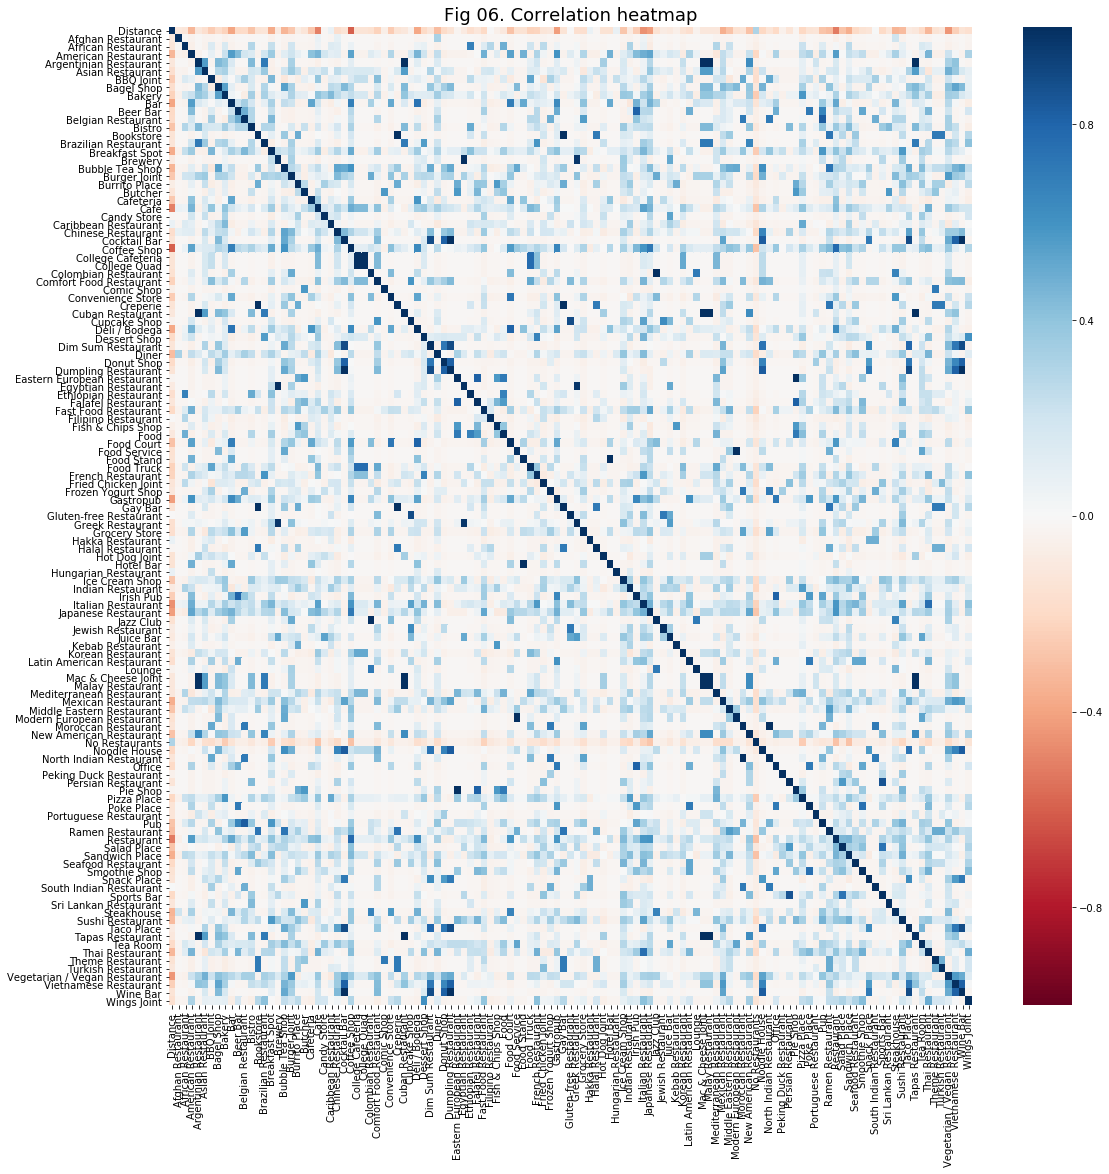

In [86]:
corr = df_correlation.corr()
(fig, ax) = plt.subplots(figsize=(18, 18))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    ax=ax,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    )
plt.title('Fig 06. Correlation heatmap', fontsize=18)
plt.show()

Key observations:

* The red markers indicate the possibility of a negative correlation between _Distance_ and number of restaurants.
* Possible positive correlations between a few restaurant types

## Relationship between the location of the neighbourhood and the number of restaurants in it.

In [87]:
df_Distance = df_correlation[['Distance']].copy()
df_Distance['RestaurantCount'] = df_correlation.drop(['Distance',
        'No Restaurants'], axis=1).sum(axis=1)
df_Distance.head()

,Distance,RestaurantCount
0,22.921869,0
1,23.216478,0
2,20.004767,4
3,18.823836,1
4,17.738704,8


In [88]:
# Correlation coefficient(r) and p-value

(r, p) = pearsonr(df_Distance['Distance'], df_Distance['RestaurantCount'])
print('Correlation coefficient: {}, p_value: {}'.format(r, p))

Correlation coefficient: -0.6292700966010896, p_value: 1.0882133680915895e-12


A correlation coefficient of -0.63 indicates a moderately strong negative correlation between the distance of a neighbourhood from the city centre and the number of restaurants located in the neighbourhood. A negligible p-value of 1.09e-12 implies the correlation is statistically significant. The following chart graphically represents the relationship between the two variables. This implies that foodservice market in Toronto is highly concentrated around the city centre and becomes sparser as we move farther. It can be speculated that the restaurant market is driven by large demand and strong competition at the centre of the city and their demand dampens toward the city limits, however, additional research is required to reach to such conclusions.

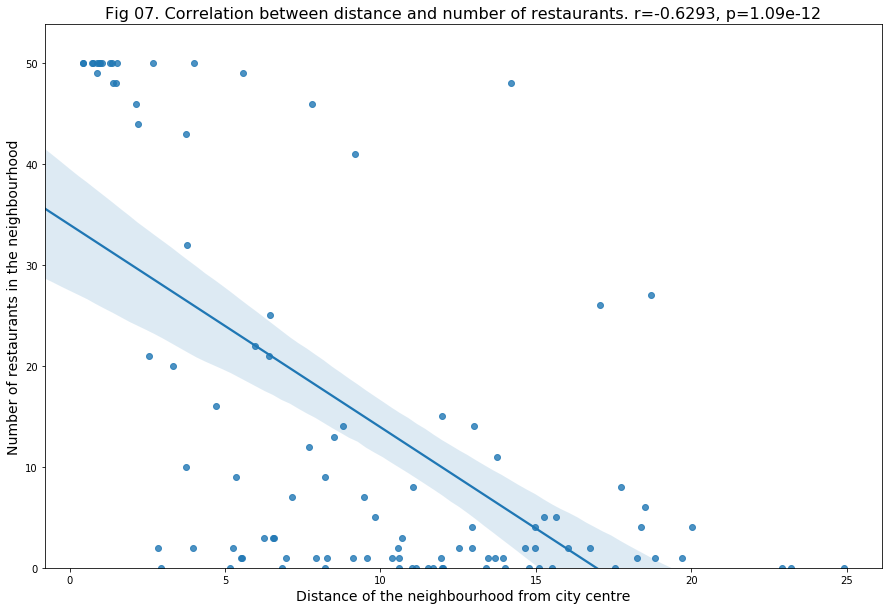

In [89]:
plt.subplots(figsize=(15, 10))
sns.regplot(x=df_Distance['Distance'], y=df_Distance['RestaurantCount'
            ]).set_title('Fig 07. Correlation between distance and number of restaurants. r={}, p={:.2e}'.format(round(r,
                         4), p), fontsize=16)
plt.ylim(0, None)
plt.ylabel('Number of restaurants in the neighbourhood', fontsize=14)
plt.xlabel('Distance of the neighbourhood from city centre', fontsize=14)
plt.show()

## Relationships between types of restaurants

### Correlations

In [90]:
# Data frame of restaurant types
df_correlation = df_Clusters.drop(["PostalCode","Neighbourhood","Distance","Cluster","Latitude","Longitude"],axis=1)
df_correlation.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


As observed in the correlation heatmap earlier (in _Fig 06_), there was some positive correlation in blue among most restaurant types. Since we are interested in moderate to strong correlations, we can ignore restaurants with mild or no correlations to reduce the clutter. Following is a visualization of restaurant types with correlation coefficients greater than 0.7.

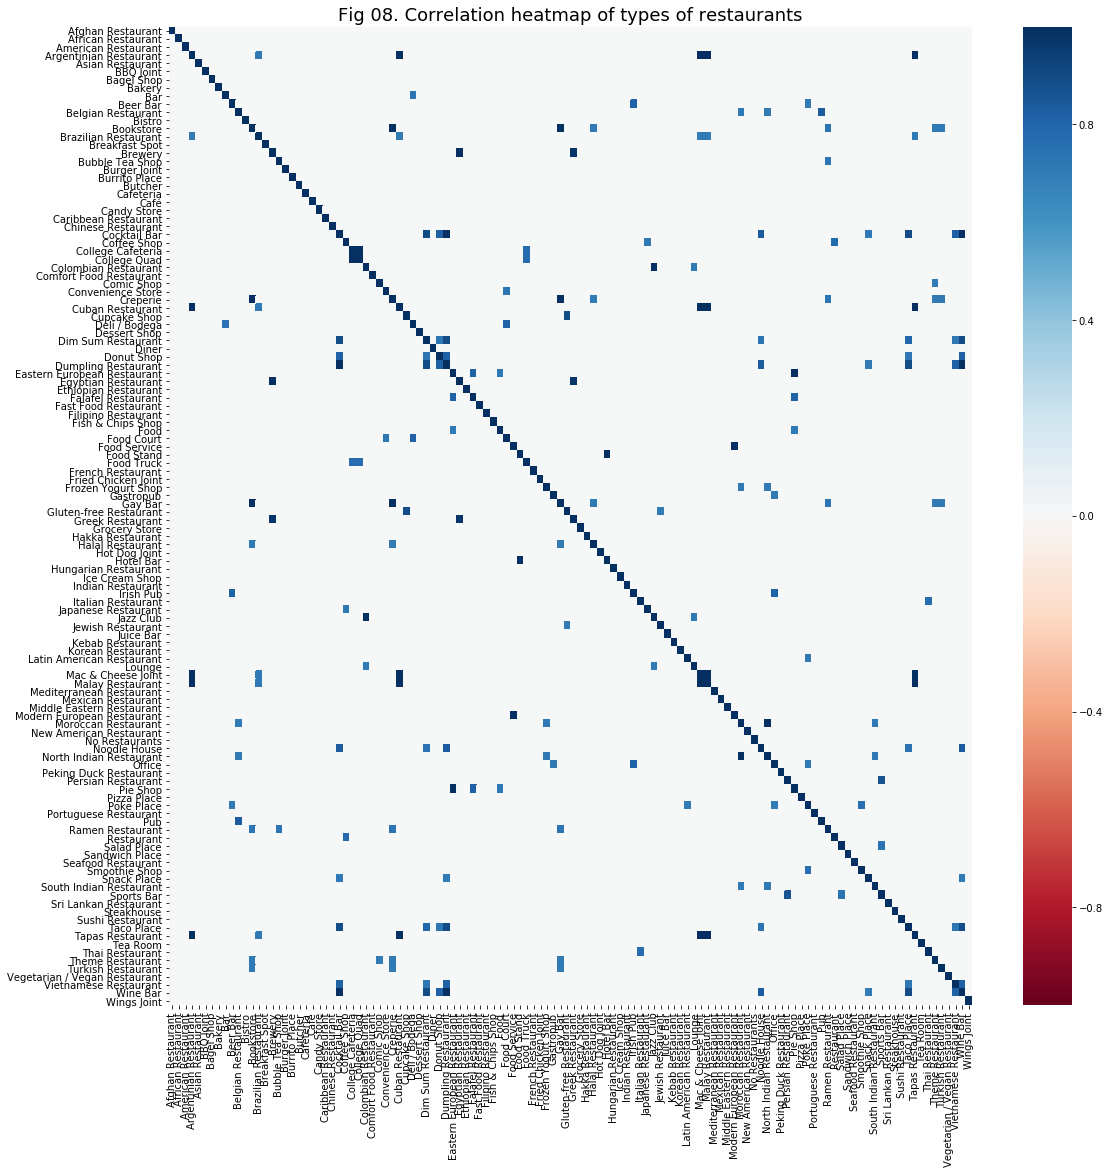

In [91]:
# Correlation between restaurant types
correlation = df_correlation.corr()
correlation = correlation.mask((correlation > -0.7) & (correlation
                               < 0.7), 0)
(fig, ax) = plt.subplots(figsize=(18, 18))
sns.heatmap(
    correlation,
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values,
    ax=ax,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    )
plt.title('Fig 08. Correlation heatmap of types of restaurants', fontsize=18)
plt.show()

Also, some restaurant pairs hold strong correlations but the number of such restaurants is so small that their correlations are practically insignificant. In this case, we are interested in correlations between restaurants that have at least five restaurants of their type in the city. Any restaurant type with less than 5 restaurants is dropped from further analysis. 

Regression coefficients (_Pearson r_) and _p-values_ are calculated from Pearsons regression. Only coefficients greater than 0.7 are considered. For a 99% confidence study, we take in to account only the restaurant pairs with _p_ less than an $\alpha$ of 0.01.

Following is the list of features and correlation heatmap of restaurant types _r_ > 0.7 and _p_ < 0.01.

In [92]:
# Adding a totals row containing the number of restaurants of each type.

df_correlation.loc['Total'] = df_correlation.sum()
df_correlation.loc['Total']

Afghan Restaurant                 1
African Restaurant                2
American Restaurant              25
Argentinian Restaurant            1
Asian Restaurant                 17
                                 ..
Turkish Restaurant                2
Vegetarian / Vegan Restaurant    21
Vietnamese Restaurant            10
Wine Bar                          1
Wings Joint                       9
Name: Total, Length: 120, dtype: int64

In [93]:
# Dropping restaurants types that have less than five restaurants in the city.

print('All restaurant types:', df_correlation.shape[1])
for col in df_correlation.columns:
    if df_correlation.loc['Total', col] < 5:
        df_correlation.drop(col, axis=1, inplace=True)
df_correlation.drop('Total', axis=0, inplace=True)
print('Restaurant types with at least 5 restaurants:', df_correlation.shape[1])

All restaurant types: 120
Restaurant types with at least 5 restaurants: 61


In [94]:
def compute_correlation(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    rmatrix = dfcols.transpose().join(dfcols, how='outer')
    featureList = []
    count = 0
    for row in df.columns:
        for col in df.columns[count:]:
            (r, p) = pearsonr(df[row], df[col])
            if abs(r - 1) > 0.01 and r > 0.7 and p < 0.01:
                featureList.append([row, col, r, p])
                rmatrix[row][col] = r
                rmatrix[col][row] = r
        count += 1
    rmatrix.fillna(value=np.nan, inplace=True)
    df_Features = pd.DataFrame(sorted(featureList, reverse=True,
                               key=lambda x: x[2]),
                               columns=['Restaurant Type 1',
                               'Restaurant Type 2',
                               "Correlation Coefficient 'r'", 'p-value'
                               ])
    return (rmatrix, df_Features)

In [95]:
(rmatrix, df_Features) = compute_correlation(df_correlation)
df_Features.shape[0]

8

Following is the list of restaurants with significant positive correlations.

In [96]:
print(tabulate(df_Features, headers='keys', tablefmt='psql',
               colalign=('left', 'left', 'left', 'center', 'center')))

+----+---------------------+---------------------+-------------------------------+-------------+
|    | Restaurant Type 1   | Restaurant Type 2   |  Correlation Coefficient 'r'  |   p-value   |
|----+---------------------+---------------------+-------------------------------+-------------|
| 0  | Deli / Bodega       | Food Court          |           0.809164            | 4.61791e-25 |
| 1  | Coffee Shop         | Restaurant          |           0.774627            | 8.09654e-22 |
| 2  | Italian Restaurant  | Thai Restaurant     |           0.765077            | 5.07373e-21 |
| 3  | Salad Place         | Sports Bar          |           0.741198            | 3.49179e-19 |
| 4  | Bar                 | Deli / Bodega       |            0.73927            | 4.81547e-19 |
| 5  | Bubble Tea Shop     | Ramen Restaurant    |           0.730993            | 1.85416e-18 |
| 6  | Convenience Store   | Food Court          |           0.721358            | 8.37724e-18 |
| 7  | Coffee Shop         | J

In [97]:
for col in rmatrix:
    if rmatrix[col].sum() == 0:
        rmatrix.drop(col, axis=1, inplace=True)
        rmatrix.drop(col, axis=0, inplace=True)
rmatrix

,Bar,Bubble Tea Shop,Coffee Shop,Convenience Store,Deli / Bodega,...,Ramen Restaurant,Restaurant,Salad Place,Sports Bar,Thai Restaurant
Bar,NaN,NaN,NaN,NaN,0.73927,...,NaN,NaN,NaN,NaN,NaN
Bubble Tea Shop,NaN,NaN,NaN,NaN,NaN,...,0.730993,NaN,NaN,NaN,NaN
Coffee Shop,NaN,NaN,NaN,NaN,NaN,...,NaN,0.774627,NaN,NaN,NaN
Convenience Store,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
Deli / Bodega,0.73927,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Ramen Restaurant,NaN,0.730993,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
Restaurant,NaN,NaN,0.774627,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
Salad Place,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.741198,NaN
Sports Bar,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.741198,NaN,NaN


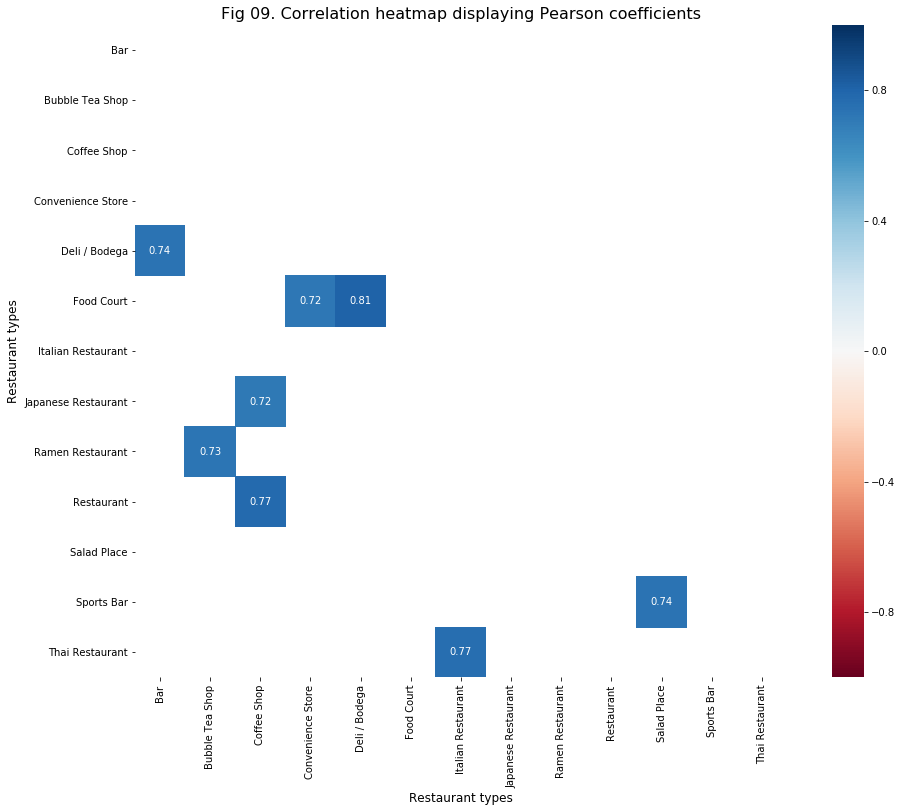

In [98]:
ax = plt.subplots(figsize=(16, 12))[1]
mask = np.zeros_like(rmatrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(
    rmatrix,
    xticklabels=rmatrix.columns.values,
    yticklabels=rmatrix.columns.values,
    mask=mask,
    ax=ax,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    annot=True,
    square=True,
    )
plt.title('Fig 09. Correlation heatmap displaying Pearson coefficients', fontsize=16)
plt.xlabel('Restaurant types', fontsize=12)
plt.ylabel('Restaurant types', fontsize=12)
plt.show()

### Regression Analysis

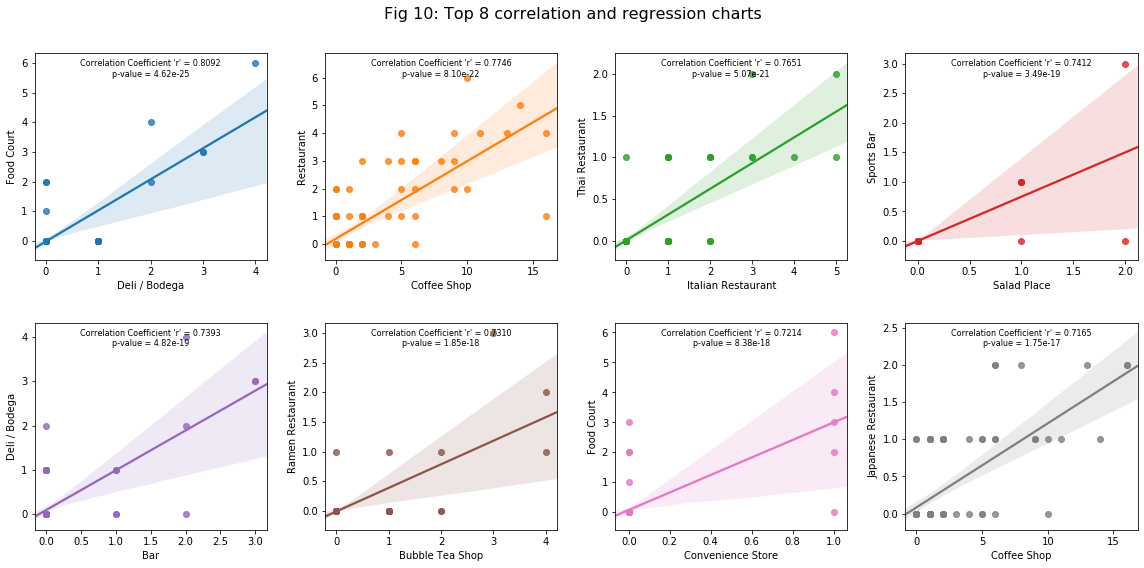

In [99]:
count = df_Features.shape[0]
cols = 4 # Number of columns of plots
scale = 4 # Plot size scale
rows = int(count / cols)
if rows * cols < count:
    rows += 1
rtxt = "Correlation Coefficient 'r'"
ptxt = 'p-value'
(fig, axs) = plt.subplots(nrows=rows, ncols=cols, figsize=(int(cols * scale),
                          int(rows * scale)))
for (i, ax) in zip(range(count), axs.flat):
    sns.regplot(x=df_correlation[df_Features['Restaurant Type 1'][i]],
                y=df_correlation[df_Features['Restaurant Type 2'][i]],
                ax=ax)
    ax.text(
        0.5,
        0.95,
        '{} = {:.4f}'.format(rtxt, df_Features[rtxt][i]),
        fontsize=8,
        ha='center',
        va='center',
        transform=ax.transAxes,
        )
    ax.text(
        0.5,
        0.90,
        '{} = {:.2e}'.format(ptxt, df_Features[ptxt][i]),
        fontsize=8,
        ha='center',
        va='center',
        transform=ax.transAxes,
        )
fig.suptitle('Fig 10: Top {} correlation and regression charts'.format(count), fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.9, hspace=0.3, wspace=0.25)
plt.show()

The above figure illustrates eight pairs of restaurant types with a strong positive correlation between each other. All the pairs have p-values much lesser than an $\alpha$ of 0.01 indicating high statistical significance. For example, in chart 1, neighbourhoods with a high number of _Food Court_ restaurants also have a relatively high number of _Deli / Bodega_ restaurants. So if someone plans to open a deli in Toronto, it may be a good idea to choose a location with a good number of food courts. Similarly, in chart 2, it may be profitable to open a coffee shop in a location with restaurants. Similar inferences can be made with all the pairs of restaurants from the charts above.

# Conclusions

In this study, cluster analysis and correlation/regression analysis are used to explore valuable insights into Toronto foodservice market. The city is divided into several clusters based on types of restaurants to give a bird's eye view of market trends. The inverse relationship between the number of restaurants in a location and the distance of the location from the city centre indicate that the restaurant industry flourishes when it's closer to the centre. Strong positive correlations between pairs of restaurants help investors to decide better on profitable locations for their new ventures

# Future directions

The study analyzes the restaurant market based on the number of restaurants in the location. The analysis can be greatly enhanced by taking profitability into account. This project could be further improved by adding factors such as demand, competition, population, etc into consideration. 

# Project links

Download/view project report: [[PDF]](https://link.datascience.eu.org/p001r1 "Project report")

View project output with code: [[Blog post]](https://www.datascience.eu.org/posts/ibm-capstone-project-code/ "Insights into Toronto’s Foodservice Market - with Source Code"), [[nbviewer]](https://link.datascience.eu.org/p001c2 "Output in Jupyter nbviewer"), [[Github]](https://link.datascience.eu.org/p001c1 "Jupyter notebook on Github")

# References

[1] “Foodservice Industry Forecast 2018-2022,” Restaurants Canada (formerly CRFA). https://www.restaurantscanada.org/resources/foodservice-industry-forecast/

[2] “The Canadian Restaurant Industry Landscape – why is Toronto Unique?” CHD Expert. https://www.chd-expert.com/blog/press_release/the-canadian-restaurant-industry-landscape-why-is-toronto-unique/

[3] “Pythagorean theorem,” Wikipedia. https://en.wikipedia.org/wiki/Pythagorean_theorem

[4] “Latitude/Longitude Distance Calculator,” National Oceanic and Atmospheric Administration - National Hurricane Center and Central Pacific Hurricane Center. https://www.nhc.noaa.gov/gccalc.shtml

[5] “Determining the number of clusters in a data set,” Wikipedia. https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_elbow_method

[6] “Pearson Correlation and Linear Regression,” University of Texas - Austin. http://sites.utexas.edu/sos/guided/inferential/numeric/bivariate/cor/

[7] “Simple Linear Regression and Correlation,” StatsDirect Limited. https://www.statsdirect.com/help/regression_and_correlation/simple_linear.htm